# <h1><center>Central Pattern Generator Tutorial</center></h1>

This notebook provides an introductory tutorial to the usage of Central Pattern Generators (CPG) for robotic locomotion.
Specifically, we cover the bio-inspired origin of CPGs and how they can be implemented using differential equations. Furthermore, we show how these differential equations can be solved numerically using Jax. Afterwards, we apply a CPG to the [Brittle Star environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star), which is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb).

## Central Pattern Generators
Central Pattern Generators (CPGs) are neural circuits that produce rhythmic patterned outputs without requiring rhythmic input. The term 'central' indicates that sensory feedback (from the peripheral nervous system) is not needed for generating the rhythms. This intrinsic capability to produce rhythmic patterns is essential for many basic life functions such as chewing, breathing, and digesting. They are also fundamental building blocks for the locomotor neural circuits both in invertebrate and vertebrate animals. CPGs present several interesting properties such as distributed control, the ability to deal with redundancies, fast control loops, and allowing modulation of the rhythmic patterns with simple control signals. These properties make CPGs interesting building blocks for locomotion controllers in robotics. 

Two primary approaches are prevalent in the implementation of Central Pattern Generators (CPGs) in robotics: the connectionist approach and the differential equations approach.

The connectionist approach involves creating CPGs through networks of interconnected artificial neurons (resulting in a recurrent neural network). The connectionist model is particularly effective for simulating adaptive behaviors, as it can learn and modify its connections based on feedback, much like a biological neural network. In essence, the connectionist approach relies on the Universal Approximation theorem of neural networks to provide a way to optimize towards any kind of rhythmic output. This approach is often employed when the targeted CPG cannot be modelled mathematically.
 
On the other hand, the differential equations approach uses mathematical models based on differential equations to simulate the rhythmic outputs of CPGs. This method relies on carefully crafted equations that describe the dynamics of the system, often focusing on the interactions between different elements of the CPG and their temporal evolution. This approach is particularly valued for its precision and predictability, allowing for a detailed understanding of the underlying mechanics of rhythmic patterns. It is widely used in more traditional engineering and robotics contexts, where precise control and predictability are essential. In essence, we can enforce specific properties of rhythmic output we desire though crafting the differential equations.

In this tutorial, we will focus on the latter approach.

## Differential equations
Before diving into an actual CPG implementation, we will take a brief side step and recap what differential equations are and what they are used for.

Differential equations are mathematical equations that describe the relationship between a function and its derivatives. They are fundamental in expressing how a quantity changes over time or space and are pivotal in modeling the behavior of diverse physical, biological, chemical, and economic systems. At their core, differential equations involve functions and their rates of change. For example, in physics, they are used to describe phenomena like the motion of a pendulum or the flow of heat in a solid. In biology, they can model population dynamics or the spread of diseases. In engineering, differential equations are crucial for designing control systems or understanding the behavior of electrical circuits. There are two main types of differential equations: ordinary differential equations (ODEs) and partial differential equations (PDEs). ODEs involve functions of a single variable and their derivatives, such as time. PDEs, on the other hand, deal with functions of multiple variables and their partial derivatives, like space and time. Solving a differential equation typically means finding the function or set of functions that satisfy the equation. The solutions can provide vital insights into the behavior of the system being modeled, predicting how it evolves over time or reacts to different conditions. Due to the complexity of many differential equations, solutions are often sought through numerical methods, especially for equations that cannot be solved analytically.

### Case study
Given our use of physics simulators, we will use a related example. Physics simulators rely on differential equations to accurately represent the dynamics of real-world phenomena. Differential equations enable the simulation of a wide array of physical processes, such as the motion of objects under the influence of forces, fluid dynamics, and even changes in temperature and energy. The motion of objects is often governed by Newton's laws of motion, which are expressed through differential equations. For example, the change in velocity (i.e. the acceleration) of an object is calculated based on the forces applied to it, encapsulating the principles of mass, force, and acceleration. Similarly, in simulating fluid dynamics, the Navier-Stokes equations – a set of nonlinear partial differential equations – are used to describe the motion of fluid substances. These simulators numerically solve these differential equations at discrete time intervals. Ultimately, physics simulators thus solve differential equations to predict the state of the system at a future point in time, given the current state (i.e. the initial/current conditions of the system).

In this case study, we will solve the differential equations that describe the motion of a point in one-dimensional space. As stated above, the motion of objects is often described by Newton's laws of motion: $F = ma$ (the second law). This law links the force $F$ we apply to an object to its mass $m$ and acceleration $a$. As you you know, acceleration $a$ is the derivative of velocity $v$ with respect to time $t$, which again is the derivative of position $p$ with respect to time. This law can thus be rewritten as $F = ma = m v' = m p''$, where $'$ denotes the derivative.

To simplify things, let's say that in our one-dimensional space, we only have a single force that acts upon the object, which we completely control. We thus know $F(t)$. We will also give our object a mass of 1 such that we can remove it from the above equations: $F = a = v' = p''$. So given a function that describes our force over time $F(t)$, we immediately know what the acceleration $a$ of our point will be. But what if we want to know the velocity over time $v(t)$? Let's work this out with a force function $F(t) = t^2$.

In [92]:
import numpy as np


def force(
        time: float
        ) -> float:
    return time ** 2


def acceleration(
        time: float,
        velocity: float
        ) -> float:
    # F = ma
    mass = 1
    return mass * force(time=time)

Note: the reason why the acceleration function also takes the velocity as an argument, is because the general form of an ODE is $y'(t) = f(t, y(t))$, i.e. the derivative of a function is a function of the independent variable and the function itself. In our case, this means that $a(t) = v'(t) = f'(t, v(t)$. So while we do not explicitly use the velocity in the calculation of our acceleration, let's keep it as an argument anyway to stay general.

Anyway, we know that $a = v'$, i.e. the derivative of our velocity with respect to time is equal to the acceleration. This means that the acceleration function describes how our velocity changes over time. If we were given the current velocity as an initial condition, i.e. $v(t_n)$, we can thus calculate $v(t_{n+1})$ by just taking a small steps in the direction of the acceleration.

In [93]:
def get_next_velocity(
        current_time: float,
        current_velocity: float,
        delta_time: float
        ) -> float:
    current_acceleration = acceleration(time=current_time, velocity=current_velocity)
    new_velocity = current_velocity + delta_time * current_acceleration
    return new_velocity

Let's use this to simulate a trajectory of `simulation_time` seconds with our point, starting from $v(t_0) = 0$.

In [94]:
simulation_time = 10
delta_time = 0.01

times = [0]
velocities = [0]

while times[-1] < simulation_time:
    next_velocity = get_next_velocity(current_time=times[-1], current_velocity=velocities[-1], delta_time=delta_time)
    velocities.append(next_velocity)
    times.append(times[-1] + delta_time)

Time to write a visualization function

In [95]:
from matplotlib import pyplot as plt


def visualize_trajectory(
        times: np.ndarray,
        quantity: np.ndarray,
        quantity_label: str,
        color: str = "blue",
        flush: bool = True
        ) -> None:
    plt.plot(times, quantity, color=color, label=quantity_label)
    if flush:
        plt.xlabel("time")
        plt.legend()
        plt.show()
        plt.close()

Now we can visualize our velocity over time.

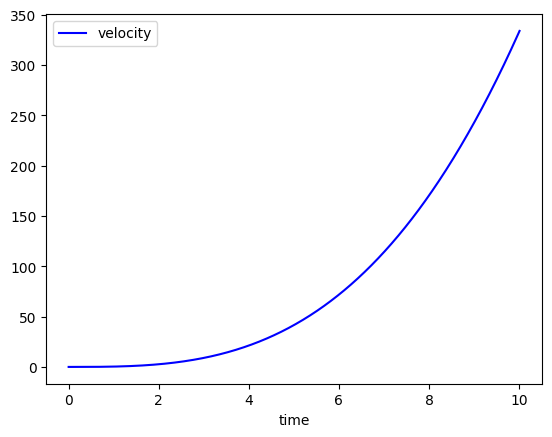

In [96]:
visualize_trajectory(times=times, quantity=velocities, quantity_label="velocity")

This is quite as expected. Our force function is $F(t) = t^2$. As discussed above, our point's acceleration $a$ follows this same function (given that we used a mass $m$ of 1). So we actually solved the ODE $a = v'$. This methodology, i.e. starting from a known initial condition and iteratively taking a small step in the direction of the derivative function (which is actually represents the slope of the original function at that point) is known as the [Euler method](https://en.wikipedia.org/wiki/Euler_method).

### Euler method
Before moving on, let's first implement our Euler 'solver' in a more general manner.

In [97]:
from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y

It's important to remember that we're actually approximating the velocity function numerically, instead of getting an exact solution. In this specific ODE where we have $v'(t) = a(t) = t^2$ and $v(0) = 0$, we can easily see that $v(t) = \frac{1}{3}t^3$ is the exact solution (plug this into the ODE to check). See what happens if we try some different `delta_time` values (i.e. different step sizes) and compare it to this exact solution.

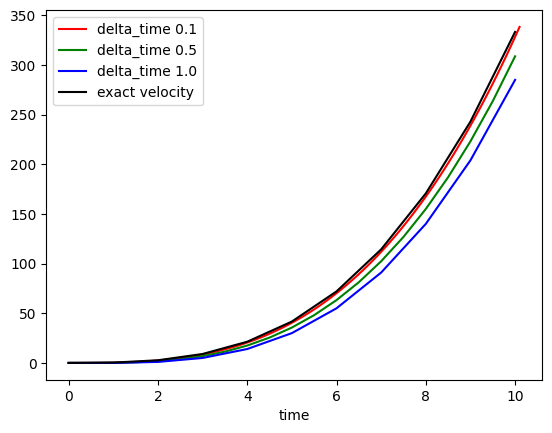

In [98]:
simulation_time = 10
delta_times = [0.1, 0.5, 1.0]
colors = ["red", "green", "blue"]

for delta_time, color in zip(delta_times, colors):
    times = [0]
    velocities = [0]

    while times[-1] < simulation_time:
        next_velocity = euler_solver(
                current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
                )
        velocities.append(next_velocity)
        times.append(times[-1] + delta_time)
    visualize_trajectory(
            times=times, quantity=velocities, quantity_label=f"delta_time {delta_time}", color=color, flush=False
            )

exact_solution = 1 / 3 * np.power(np.array(times), 3)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="exact velocity", color="black", flush=True)

We can see that the smaller our step size, the better the approximation! This is because we linearly approximate the change of our function $v(t)$ over time (by taking a step in the direction of our slope at each point), while the true change of our function (in this case $a(t) = t^2$) is non-linear! This approximation only remains sufficiently close to the true solution if we take small enough steps, at the cost of more computation.

Sidenote: When you solve an ODE, you are essentially integrating the differential equation. The ODE describes the change over time, integrating this change over time (i.e. taking a 'sum' of all change over time), gives us the current 'state' at each time. 

This Euler method is a member of the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). The Euler method is the simplest form of the Runge-Kutta methods and can be considered a first-order Runge-Kutta method. As shown above, it approximates the solution of an ODE by taking a series of steps along the curve, using the slope of the curve (derived from the ODE) at the beginning of each step to predict the value of the function at the next step. The process is akin to taking small, linear steps along the curve, each step based only on the immediate slope. In contrast, higher-order Runge-Kutta methods, such as the popular fourth-order Runge-Kutta method (RK4), take a more sophisticated approach. They use multiple evaluations of the slope (derivative) at various points within each step to make a more accurate prediction for the next value. These methods effectively use additional information about the curvature and behavior of the function within each step to refine their predictions. So at the cost of more function evaluations, it provides better slope approximations.

### Runge-Kutta methods
Let's implement an RK4 solver (4 refers to 4 slope approximations via 4 derivative function evaluations).

In [99]:
def rk4_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # This is the original euler
    slope1 = derivative_fn(current_time, y)
    # These are additional slope calculations that improve our approximation of the true slope  
    slope2 = derivative_fn(current_time + delta_time / 2, y + slope1 * delta_time / 2)
    slope3 = derivative_fn(current_time + delta_time / 2, y + slope2 * delta_time / 2)
    slope4 = derivative_fn(current_time + delta_time, y + slope3 * delta_time)
    average_slope = (slope1 + 2 * slope2 + 2 * slope3 + slope4) / 6
    next_y = y + average_slope * delta_time
    return next_y

Let's compare the euler and RK4 approximations!

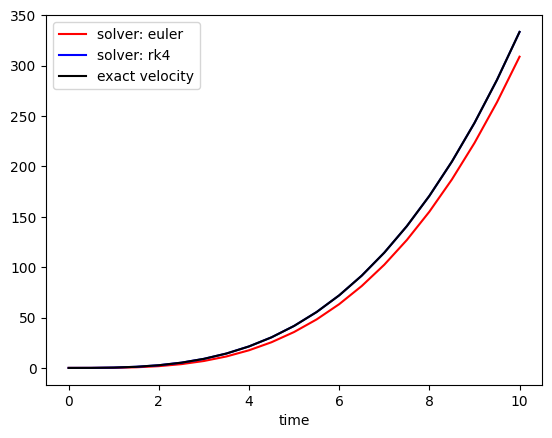

In [100]:
simulation_time = 10
delta_time = 0.5
solvers = [euler_solver, rk4_solver]
solver_names = ["euler", "rk4"]
colors = ["red", "blue"]

for solver, solver_name, color in zip(solvers, solver_names, colors):
    times = [0]
    velocities = [0]

    while times[-1] < simulation_time:
        next_velocity = solver(
                current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
                )
        velocities.append(next_velocity)
        times.append(times[-1] + delta_time)
    visualize_trajectory(
            times=times, quantity=velocities, quantity_label=f"solver: {solver_name}", color=color, flush=False
            )

exact_solution = 1 / 3 * np.power(np.array(times), 3)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="exact velocity", color="black", flush=True)

As you can see, our RK4 solver solves the ODE better than our orignal Euler (which could also be written as RK1). We can even say that the RK4 solver provides an exact solution to the ODE because if the exact solution to the differential equation is a polynomial of order $n$, it will be solved exactly by an $n$-th order Runge-Kutta method. The slope approximations that appear in the RK$n$ methods are based on a Taylor series approximation of the true slope. Diving into that is a bit out of scope for this tutorial, but feel free to head to dive a little bit deeper yourself.

### Second-order differential equations 
The velocity and acceleration example from above is an example of a first-order ODE (i.e. the highest order of a derivative in the ODE is one). We used the euler and RK4 methods to solve for the velocity $v(t)$ given an acceleration function $a(t)$. If we now want to find our point's position $p(t)$ over time, we get the following second-order ODE: $a(t) = p''(t)$. The nice thing is that we can reuse or previous solution to do so! Since we already solved the $a(t) = v'(t)$, we know the (approximated) value of the velocity function $v(t)$. So we can just solve another first order ODE instead: $v(t) = p'(t)$!


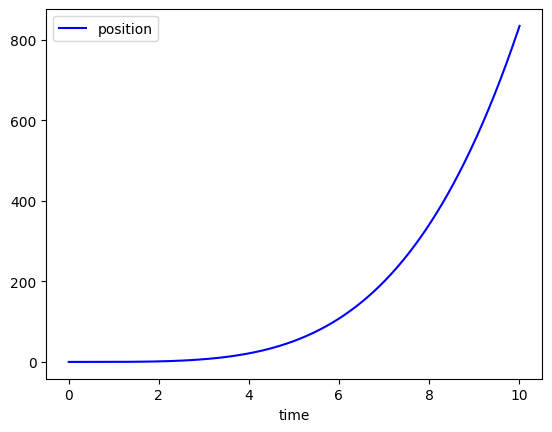

In [101]:
times = [0]
positions = [0]
velocities = [0]
delta_time = 0.01

while times[-1] < 10:
    next_velocity = rk4_solver(
            current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
            )
    next_position = rk4_solver(
            current_time=times[-1],
            y=positions[-1],
            derivative_fn=lambda
                t,
                p: velocities[-1],
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(next_position)
    velocities.append(next_velocity)

visualize_trajectory(times=times, quantity=positions, quantity_label="position")

Knowing that $v(t) = \frac{1}{3}t^3$ and that $v(0) = 0$, we can again see that the exact solution would be $p(t) = \frac{1}{3 * 4}t^4$. Let's compare our previous result to the exact solution as a validation.

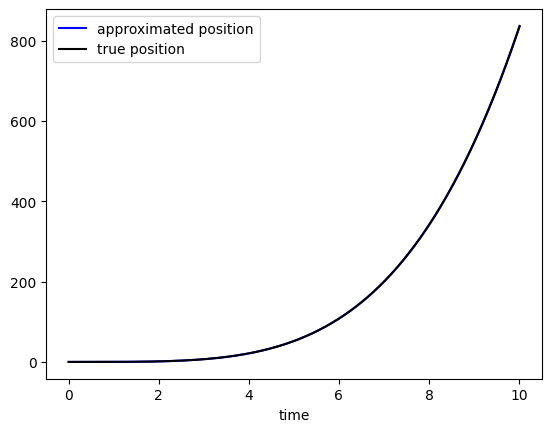

In [102]:
visualize_trajectory(times=times, quantity=positions, quantity_label="approximated position", flush=False)
exact_solution = 1 / 12 * np.power(times, 4)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="true position", color="black", flush=True)

Solving a second-order ODE thus comes down to solving two first-order ODEs. We solved $p'' = a = t^2$ with initial conditions $p(0) = 0, p'(0) = v(0) = 0$. We did this by first solving $v'(t) = t^2$ with the initial condition $v(0) = 0$. Every step, this gives us $v(t_{n+1}})$
Then we solve $p(t)' = v(t)$ with the initial condition $p(0) = 0$. In every step, we approximate $v(t)$ as a constant, given that we calculated it in the previous step (or know it as an initial condition due to $p'(0) = v(0)$ being given).

In a more general form, let's say we we have a second-order ODE: $y'' + y' + y = c$  with initial conditions $y(0) = a, y'(0) = b$
If we let $y_1 = y$ and $y_2 = y'$, we can write the original second-order ODE as a system of two first-order ODEs:
$\begin{bmatrix} y_1' \\ y_2'\end{bmatrix} = \begin{bmatrix} y_2 \\ c - y_1 - y_2\end{bmatrix}$ with initial conditions: $\begin{bmatrix} y_1(0) \\ y_2(0)\end{bmatrix} = \begin{bmatrix} a \\ b\end{bmatrix}$. In this manner, we can use our first-order ODE solvers to solve second-order ODEs (and even higher order ODEs) by decomposing them.

Note: although our case study focused on solving ordinary differential equations, the same methodology can be employed for partial differential equations.

## Implementing a Central Pattern Generator

TODO: DISCUSS THE SIN FUNCTION AS THE SIMPLEST FORM OF A CPG AND DISCUSS WHY WE WOULD USE THE SPROEWITZ MODEL INSTEAD

Now that we refreshed our intuition with respect to using and solving differential equations, we can finally move on to the actual implementation of a CPG. We will implement the CPG model used in a paper by [Sproewitz et al](https://journals.sagepub.com/doi/10.1177/0278364907088401). This CPG model is implemented as a system of $N$ coupled amplitude- and offset-controlled phase oscillators. An oscillator $i$ is defined by the following differential equations (the $\dot$ refers to the derivative operator, which we previously used $`$ for): 

(1) $\dot{\phi_i} = \omega_i + \sum_j{w_{ij}r_j}\sin{(\phi_j - \phi_i - \rho_{ij})}$<br>
(2) $\ddot{r_i} = a_r(\frac{a_r}{4}(R_i - r_i) - \dot{r_i})$<br>
(3) $\ddot{x_i} = a_x(\frac{a_x}{4}(X_i - x_i) - \dot{x_i})$<br>
(4) $\theta_i = x_i + r_i\cos{(\phi_i)}$<br>

where $\theta_i$ is the output of the oscillator (in radians) and $\phi_i$ , $r_i$ and $x_i$ are state variables that respectively encode the phase, amplitude and the offset of the oscillations. The parameters $\omega_i$ , $R_i$ and $X_i$ are control parameters for the desired frequency, amplitude and offset of the oscillations. The parameters $w_{ij}$ and $\rho_{ij}$ are respectively the coupling weights and phase biases, which determine how oscillator $j$ influences oscillator $i$. The parameters $a_r$ and $a_x$ are constant positive gains.

These equations were designed such that the output of the oscillator $i$ exhibits limit cycle behavior, i.e. produces a stable periodic output. Equation (1) determines the time evolution of the phases of the oscillators.

Similar to the paper, we will use the same frequency parameter $\omega_i = \omega$ for all oscillators, and bi-directional couplings between oscillators such that $\rho_{ij} = -\rho_{ji}$. We also ensure that, in case of a closed loop of inter-oscillator couplings, all phase biases in the loop are consistent (i.e. sum to a multiple of $2\pi$). With these parameters, the phases will converge to a regime in which they grow linearly with a common rate $\omega$ and with a phase difference between oscillators determined by $\rho_{ij}$. Equations (2) and (3) are critically damped second-order [linear differential equations](https://en.wikipedia.org/wiki/Linear_differential_equation) which respectively have $R_i$ and $X_i$ as stable fixed points. This means that from any initial conditions, the state variables $r_i$ and $x_i$ will asymptotically and monotonically converge to $R_i$ and $X_i$. This allows one to smoothly modulate the amplitude and offset of oscillations.

With these settings, two oscillators $i$ and $j$ that are coupled with non-zero weights $w_{ij}$ asymptotically converge to limit cycles (i.e. a closed trajectory in the state space that corresponds to sustained oscillations without decay or growth) $\Theta_i^\infty$ and $\Theta_j^\infty$ with the following closed form (i.e. exact) solutions:

$\Theta_i^\infty = X_i + R_i\cos{(\omega t + \rho_{ij} + \phi_0)}$<br>
$\Theta_j^\infty = X_j + R_j\cos{(\omega t + \rho_{ji} + \phi_0)}$<br>
where $\phi_0$ depends on the initial conditions of the system. Note that, because of the common frequency $\omega$ and phase biases $\phi_{ij}$ in a loop, this behaviour does not depend on the coupling weights $w_{ij}$. The coupling weights only affect how quickly the system converges: the larger the weights, the faster the convergence. This means that the system stabilizes into oscillations that are phase-locked for all oscillators that are connected together. These oscillations can be modulated (i.e. controlled) by several control parameters, $\omega$ for setting a common frequency, $\rho_{ij}$ for setting the phase lags between two connected oscillators, $R_i$ for setting the individual amplitudes and $X_i$ for setting the individual offsets.

This CPG model has several nice properties:
1. The system exhibits limit cycle behavior, i.e. oscillations rapidly return to the steady-state oscillations after any transient perturbation of the state variables
2. This limit cycle has a closed form solution. Most types of oscillators used to build CPGs do not have a closed form solution for their limit cycle. The limit cycle has a harmonic shape and has control parameters ($\omega$, $R_i$ and $X_i$) that are explicit and are directly related to relevant features of the oscillations. This facilitates the design and analysis of locomotion controllers. 
3. A third interesting property is that these control parameters can be abruptly and/or continuously varied while inducing only smooth changes in the resulting oscillations (i.e. there are no discontinuities nor jerks). This property is important in avoiding damage in the motors and gearboxes of robots.

Let's now implement this model for a system with 2 bi-directionally coupled oscillators in JAX. (TODO: add image)
We can begin by defining a datastructure that we can use to keep our CPG's state in.

In [122]:
from flax import struct
import jax
import jax.numpy as jnp


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

Now we can define our constants:

In [145]:
# Constants
NUM_OSCILLATORS = 2
AMPLITUDE_GAIN = 20
OFFSET_GAIN = 20
ADJACENCY_MATRIX = jnp.ones((NUM_OSCILLATORS, NUM_OSCILLATORS)) - jnp.identity(2)
WEIGHTS = ADJACENCY_MATRIX * 5
SIMLATION_TIME = 20

Now we can implement the first equation (i.e. the phase differential equation).

In [146]:
def phase_de(
        omegas: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray,
        phase_biases: jnp.ndarray
        ) -> jnp.ndarray:
    @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
    def sine_term(
            phase_i: float,
            phase_biases_i: float
            ) -> jnp.ndarray:
        return jnp.sin(phases - phase_i - phase_biases_i)

    couplings = jnp.sum(WEIGHTS * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
    return omegas + couplings


The amplitude and offset equations have the same structure, so we can implement them just once in a reusable form. Note that these are second-order differential equations, so as previously shown, we will decompose it into two first-order differential equations:

In [147]:
def second_order_de(
        gain: jnp.ndarray,
        modulator: jnp.ndarray,
        values: jnp.ndarray,
        dot_values: jnp.ndarray
        ) -> jnp.ndarray:
    return gain * ((gain / 4) * (modulator - values) - dot_values)


def first_order_de(
        dot_values: jnp.ndarray
        ) -> jnp.ndarray:
    return dot_values

And finally, the output equation

In [148]:
def output(
        offsets: jnp.ndarray,
        amplitudes: jnp.ndarray,
        phases: jnp.ndarray
        ) -> jnp.ndarray:
    return offsets + amplitudes * jnp.cos(phases)

Given the above functions, we can now define a 'step' function that implements a CPG state transition like this: 

In [149]:
# Remember: derivative_fn expects (time, y)
def step_cpg(
        delta_time: float,
        state: CPGState,
        solver: Callable,
        # Modulation parameters
        omegas: jnp.ndarray,
        R: jnp.ndarray,
        X: jnp.ndarray,
        rhos: jnp.ndarray
        ) -> CPGState:
    # Update phase
    new_phases = solver(
            current_time=state.time,
            y=state.phases,
            derivative_fn=lambda
                t,
                y: phase_de(
                    omegas=omegas, amplitudes=state.amplitudes, phases=y, phase_biases=rhos
                    ),
            delta_time=delta_time
            )
    new_dot_amplitudes = solver(
            current_time=state.time,
            y=state.dot_amplitudes,
            derivative_fn=lambda
                t,
                y: second_order_de(gain=amplitude_gain, modulator=R, values=state.amplitudes, dot_values=y),
            delta_time=delta_time
            )
    new_amplitudes = solver(
            current_time=state.time,
            y=state.amplitudes,
            derivative_fn=lambda
                t,
                y: first_order_de(dot_values=state.dot_amplitudes),
            delta_time=delta_time
            )
    new_dot_offsets = solver(
            current_time=0,
            y=state.dot_offsets,
            derivative_fn=lambda
                t,
                y: second_order_de(gain=offset_gain, modulator=X, values=state.offsets, dot_values=y),
            delta_time=delta_time
            )
    new_offsets = solver(
            current_time=0,
            y=state.offsets,
            derivative_fn=lambda
                t,
                y: first_order_de(dot_values=state.dot_offsets),
            delta_time=delta_time
            )

    new_outputs = output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
    return state.replace(
            phases=new_phases,
            dot_amplitudes=new_dot_amplitudes,
            amplitudes=new_amplitudes,
            dot_offsets=new_dot_offsets,
            offsets=new_offsets,
            outputs=new_outputs,
            time=state.time + delta_time
            )

When solving differential equations, we always need to start from some initial conditions, so let's create a function gives us our initial CPG state.
We can use random values for this, as our CPG model should be able to stabilize.

In [150]:
# Initial conditions
def get_random_initial_state(
        rng: jnp.ndarray
        ) -> CPGState:
    phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
    state = CPGState(
            phases=jax.random.uniform(
                key=phase_rng,
                shape=(NUM_OSCILLATORS,),
                dtype=jnp.float32,
                minval=jnp.pi,
                maxval=jnp.pi
                ),
            amplitudes=jax.random.uniform(key=phase_rng, shape=(NUM_OSCILLATORS,), dtype=jnp.float32, minval=0, maxval=1),
            offsets=jax.random.uniform(key=phase_rng, shape=(NUM_OSCILLATORS,), dtype=jnp.float32, minval=-1, maxval=1),
            dot_amplitudes=jnp.zeros(adjacency_matrix.shape[0]),
            dot_offsets=jnp.zeros(adjacency_matrix.shape[0]),
            outputs=jnp.zeros(adjacency_matrix.shape[0]),
            time=0.0
            )
    return state

Time to test!

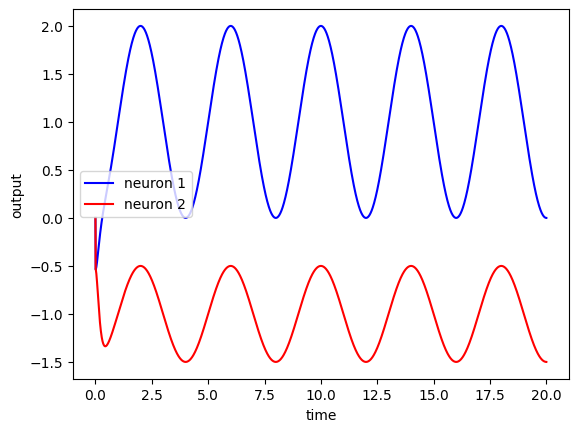

In [154]:
import functools

# Modulation parameters
omegas = (jnp.pi / 2) * np.ones(num_oscillators)
R = jnp.array([1.0, 0.5])
X = jnp.array([1.0, -1.0])
rhos = adjacency_matrix * jnp.array([[jnp.pi], [-jnp.pi]])

rng = jax.random.PRNGKey(seed=0)

dt = 0.01
states = [get_random_initial_state(rng=rng)]
jit_step = jax.jit(functools.partial(step_cpg, solver=rk4_solver))
while states[-1].time < SIMLATION_TIME:
    state = jit_step(
            delta_time=dt, state=states[-1], omegas=omegas, R=R, X=X, rhos=rhos
            )
    states.append(state)

times = [state.time for state in states]
o1 = [state.outputs[0] for state in states]
o2 = [state.outputs[1] for state in states]

plt.plot(times, o1, color="blue", label="neuron 1")
plt.plot(times, o2, color="red", label="neuron 2")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close()

Cool! We can indeed see that our oscillators (1) converge to a limit cycle (steady-state oscillations), even though we have random initial conditions, (2) the two oscillators indeed converge to the given target amplitudes $R_0=1$ and $R_1=0.5$, (3) the two oscillators indeed converge to the given target offsets $X_0=1$ and $X_1=-1$, and (4)  the two oscillators indeed exhibit our requested phase lag $\pi$, making them run in anti-phase.

What if we were to swap our amplitude and offset modulation parameters for both oscillators at $t=10$?

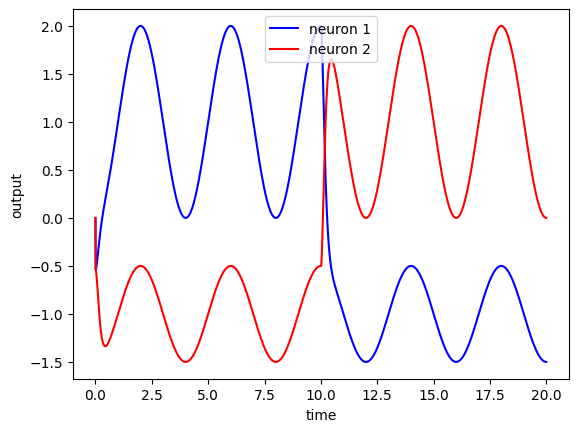

In [155]:
# Modulation parameters
omegas = (jnp.pi / 2) * np.ones(num_oscillators)
rhos = adjacency_matrix * jnp.array([[jnp.pi], [-jnp.pi]])

rng = jax.random.PRNGKey(seed=0)

dt = 0.01
states = [get_random_initial_state(rng=rng)]
jit_step = jax.jit(functools.partial(step_cpg, solver=rk4_solver))
while states[-1].time < SIMLATION_TIME:
    if states[-1].time < 10:
        R = jnp.array([1.0, 0.5])
        X = jnp.array([1.0, -1.0])
    else:
        R = jnp.array([0.5, 1.0])
        X = jnp.array([-1.0, 1.0])
        
    state = jit_step(
            delta_time=dt, state=states[-1], omegas=omegas, R=R, X=X, rhos=rhos
            )
    states.append(state)

times = [state.time for state in states]
o1 = [state.outputs[0] for state in states]
o2 = [state.outputs[1] for state in states]

plt.plot(times, o1, color="blue", label="neuron 1")
plt.plot(times, o2, color="red", label="neuron 2")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close()

Cheers! Take some time to play around with these parameters now. A good way to get a better intuition into the usage of CPGs is to try to predict the influence of some parameter changes before running them.